In [1]:
import numpy as np
import pyedflib
import matplotlib.pyplot as plt
import connectivipy as cp
import networkx as nx
import math

In [2]:
file_name = "S071_S071R02"

## 1. Connectivity

Opening and reading first EEG data file.

In [3]:
f = pyedflib.EdfReader('data/{}.edf'.format(file_name))
n = f.signals_in_file
signal_labels = f.getSignalLabels()
sigbufs = np.zeros((n, f.getNSamples()[0]))
for i in np.arange(n):
    sigbufs[i, :] = f.readSignal(i)

In [4]:
N, M = sigbufs.shape

In [5]:
# remove dots from channel labels
signal_labels = [signal.strip('.') for signal in signal_labels]

In [6]:
label_dict = {i: signal_labels[i] for i in range(N)}

### Experiment details

In [7]:
# https://github.com/holgern/pyedflib/blob/master/demo/readEDFFile.py

print("edfsignals: %i" % f.signals_in_file)
print("file duration: %i seconds" % f.file_duration)
print("startdate: %i-%i-%i" % (f.getStartdatetime().day,f.getStartdatetime().month,f.getStartdatetime().year))
print("starttime: %i:%02i:%02i" % (f.getStartdatetime().hour,f.getStartdatetime().minute,f.getStartdatetime().second))
print("datarecord duration: %f seconds" % f.getFileDuration())
print("number of datarecords in the file: %i" % f.datarecords_in_file)
print("number of annotations in the file: %i" % f.annotations_in_file)
channel = 0
print("\nsignal parameters for the %d.channel:\n" % channel)
print("label: %s" % f.getLabel(channel))
print("samples in file: %i" % f.getNSamples()[channel])
print("physical dimension: %s" % f.getPhysicalDimension(channel))
print("prefilter: %s" % f.getPrefilter(channel))
print("transducer: %s" % f.getTransducer(channel))
print("samplefrequency: %f" % f.getSampleFrequency(channel))

edfsignals: 64
file duration: 61 seconds
startdate: 12-8-2009
starttime: 16:15:00
datarecord duration: 61.000000 seconds
number of datarecords in the file: 61
number of annotations in the file: 1

signal parameters for the 0.channel:

label: Fc5.
samples in file: 9760
physical dimension: uV
prefilter: HP:0Hz LP:0Hz N:0Hz
transducer: BCI2000
samplefrequency: 160.000000


In [8]:
f.close()

### Find the best order p of the MVAR model

In [9]:
def AIC(p,M,N,Sp):
    aic=M*math.log(np.linalg.det(Sp))+(2*N**2*p)
    return aic

In [10]:
def optimal_order(number_of_orders, data):
    minimum=99999999999
    optim_order=0
    aic_list=[]
    p_list=[]
    for i in range(1, number_of_orders):
        p_list.append(i)

        data.fit_mvar(i, 'yw')
        ar, vr = data.mvar_coefficients
        aic_list.append(AIC(i,M,N,vr))


        if AIC(i,M,N,vr)< minimum:
            minimum=AIC(i,M,N,vr)
            optim_order=i
    return aic_list,p_list,minimum,optim_order

### FItting the model

In [11]:
def fit_model(data, method):
    aic, p, minimum, optim_order = optimal_order(20, data)
    print("Optimal order is", optim_order)
    print(minimum)
    plt.plot(p,aic)
    plt.show()
    data.fit_mvar(optim_order, 'yw')
    values = data.conn(method)
    significance = data.significance(Nrep=30, alpha=0.05)
    return significance
    

#### Estimating functional brain connectivity using Partial Directed Coherence (PDC)

/home/peikova/anaconda3/envs/bioinfo/lib/python3.7/site-packages/connectivipy/mvar/fitting.py:267: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  req = np.vstack(rr_b[:, :, x].T for x in range(1, pmax+1))


Optimal order is 7
1663455.1428923898


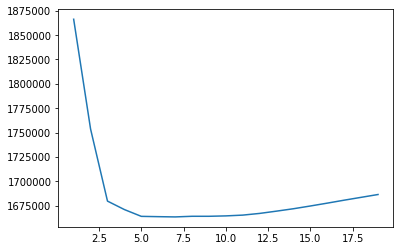

. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . |


In [12]:
data = cp.Data(sigbufs, 160, signal_labels)
pdc_significance = fit_model(data, "pdc")

### Finding threshold

In [13]:
def apply_threshold(significance, threshold, label_dictionary, positions=None):
    # apply threshold
    adj_matrix = np.where(significance>threshold, 1, 0)
    # remove self loops
    np.fill_diagonal(adj_matrix, 0)
    print("Number of edges: ", np.sum(adj_matrix))
    G = nx.DiGraph(adj_matrix)
    # calculate density
    print("Density:", nx.density(G))
    G = nx.relabel_nodes(G, label_dictionary)
    return adj_matrix, G
    

In [14]:
threshold = 0.09

adj_matrix, G_pdc = apply_threshold(pdc_significance, threshold, label_dict)

Number of edges:  813
Density: 0.20163690476190477


### Graphical representation of the binary adjacency matrix. 

In [15]:
def plot_network(G, positions=None):
    if not positions:
        positions = nx.circular_layout(G)
    plt.figure(1, figsize=(8,8)) 
    nx.draw(G, positions, with_labels=True, node_size=[400]*N)
    plt.show()

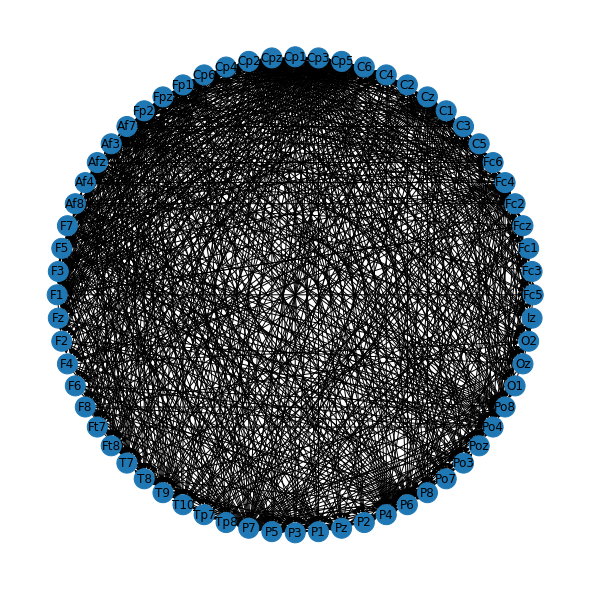

In [16]:
plot_network(G_pdc)

In [17]:
def plot_binary_heatmap(binary_adj_matrix):
    plt.figure(1, figsize=(6, 6)) 
    plt.xticks([])
    plt.yticks([])
    plt.imshow(binary_adj_matrix)
    plt.show()
    

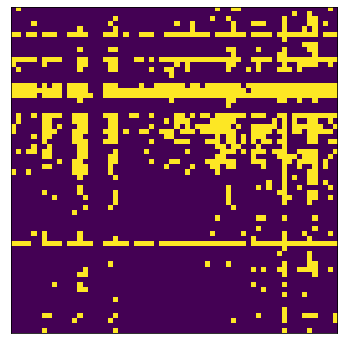

In [18]:
plot_binary_heatmap(adj_matrix)

## 1.2

/home/peikova/anaconda3/envs/bioinfo/lib/python3.7/site-packages/connectivipy/mvar/fitting.py:267: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  req = np.vstack(rr_b[:, :, x].T for x in range(1, pmax+1))


Optimal order is 7
1663455.1428923898


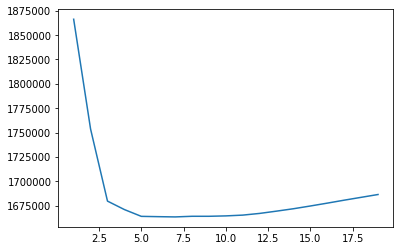

. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . |


In [19]:
dtf_significance = fit_model(data, "dtf")

In [20]:
def plot_threshold(threshold, significance, label_dictionary):
    adj_matrix, G = apply_threshold(significance, threshold, label_dictionary)
    plot_network(G)
    plot_binary_heatmap(adj_matrix)
    return G

Number of edges:  822
Density: 0.20386904761904762


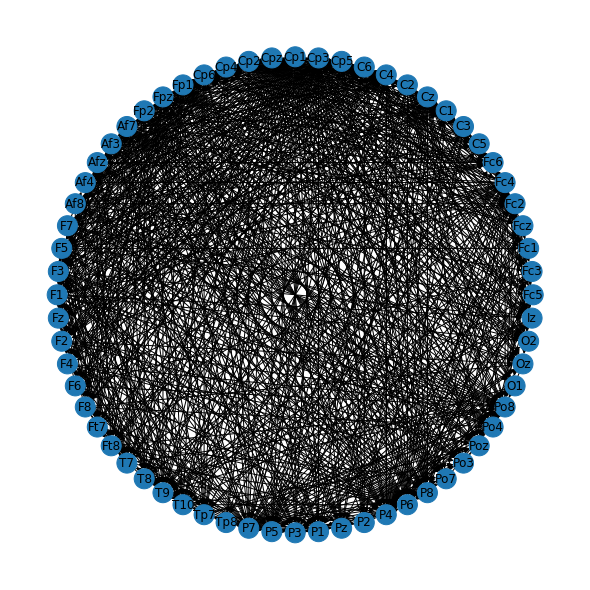

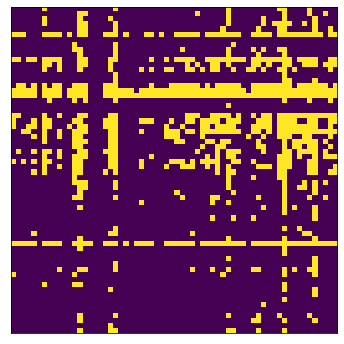

In [21]:
threshold = 0.091

G_dtf = plot_threshold(threshold, dtf_significance, label_dict)

## 1.3

### 1%

Number of edges:  61
Density: 0.015128968253968254


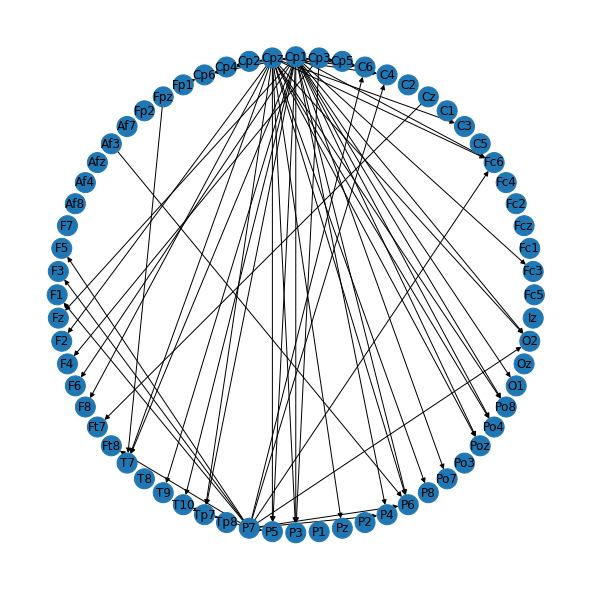

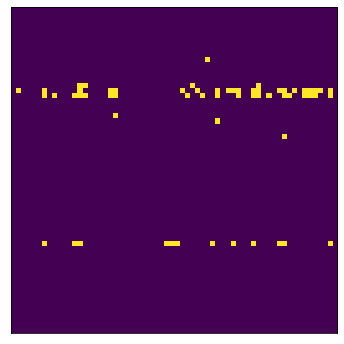

In [22]:
threshold = 0.15
pdc1 = plot_threshold(threshold, pdc_significance, label_dict)

### 5%

Number of edges:  202
Density: 0.05009920634920635


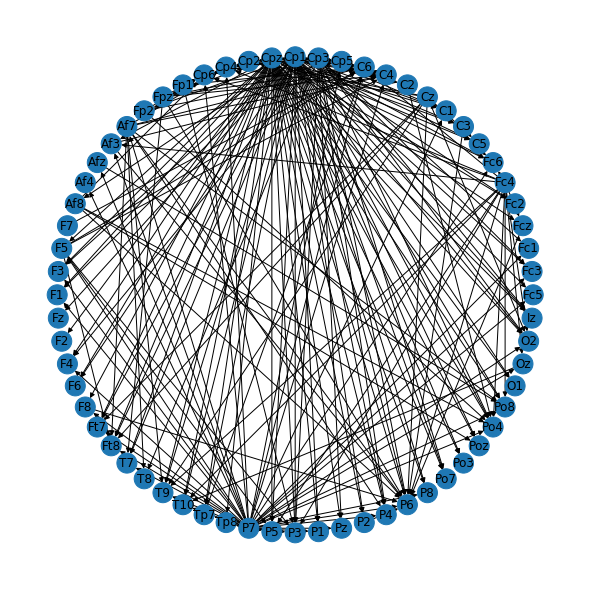

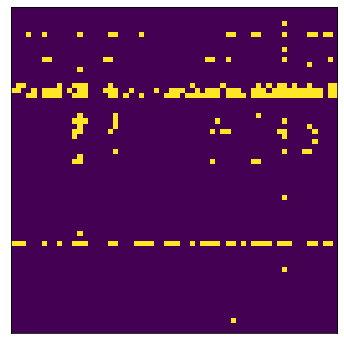

In [23]:
threshold = 0.12
pdc5 = plot_threshold(threshold, pdc_significance, label_dict)

### 10%

Number of edges:  406
Density: 0.10069444444444445


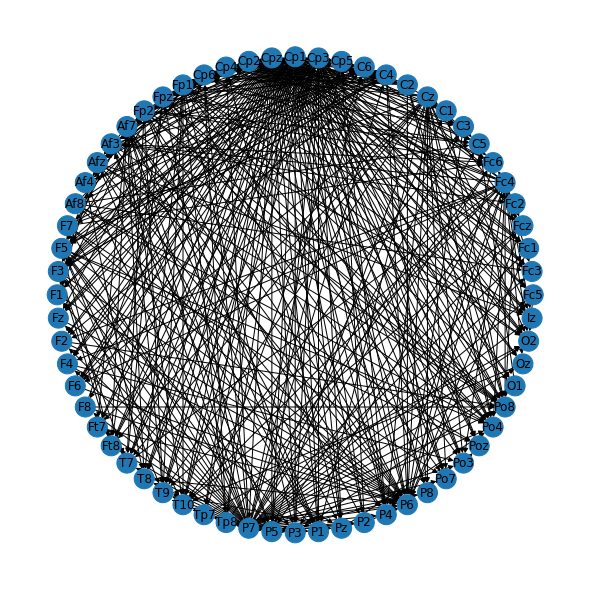

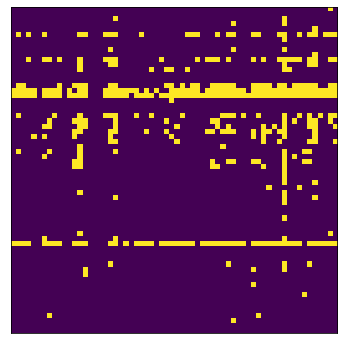

In [24]:
threshold = 0.105
pdc10 = plot_threshold(threshold, pdc_significance, label_dict)

### 30%

Number of edges:  1281
Density: 0.3177083333333333


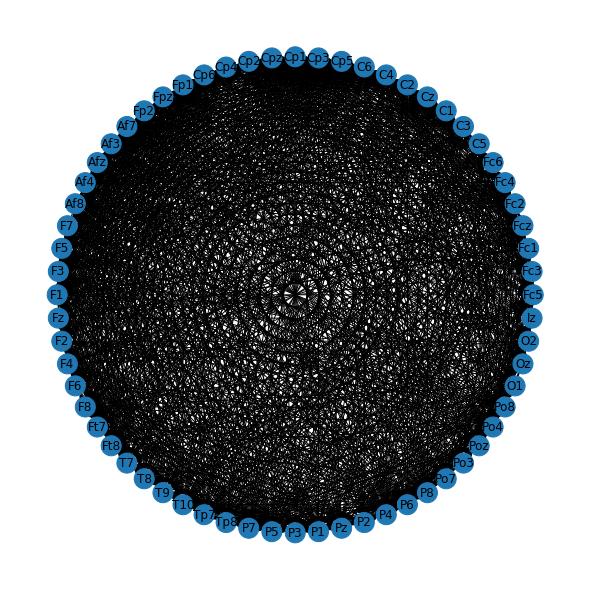

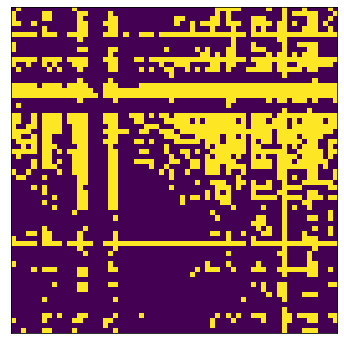

In [25]:
threshold = 0.08
pdc30 = plot_threshold(threshold, pdc_significance, label_dict)

### 50%

Number of edges:  1999
Density: 0.4957837301587302


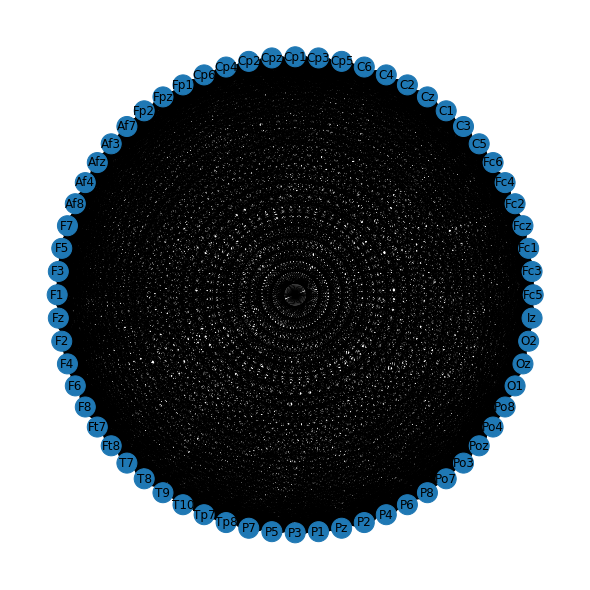

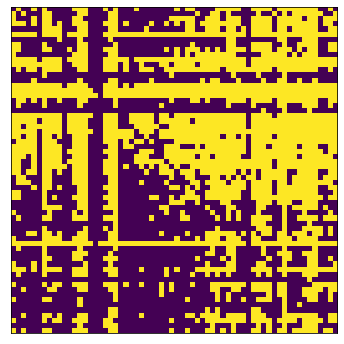

In [26]:
threshold = 0.07
pdc50 = plot_threshold(threshold, pdc_significance, label_dict)

## 1.4

In [27]:
labels_19 = ['Fp1','Fp2','F7','F3','Fz','F4','F8','T7','C3','Cz','C4','T8','P7','P3','Pz','P4','P8','O1','O2']
labels_dict_19 = dict(filter(lambda x: x[1] in labels_19, label_dict.items()))

In [28]:
# select 19 channels form signal matrix
bufs_19 = sigbufs[list(labels_dict_19.keys())]
# transform integer indices according to 19 channels
labels_dict_19 = {i: list(labels_dict_19.values())[i] for i in range(len(labels_19))}

In [29]:
# sanity check of dimensionality
bufs_19.shape

(19, 9760)

#### Fitting model

Optimal order is 3
673812.2520657053


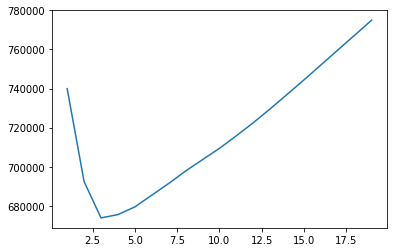

. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . |


In [30]:
data = cp.Data(bufs_19, 160, labels_dict_19.values())
pdc_significance_19 = fit_model(data, "pdc")

In [31]:
adj_matrix, G = apply_threshold(pdc_significance_19, 0.065, labels_dict_19)

Number of edges:  50
Density: 0.14619883040935672


## 1.5

#### Read file with node positions

In [32]:
with open("data/channel_locations.txt") as file:
    lines = [line.split(" "*8)[1:] for line in file.read().splitlines()]
positions = lines[1:]

In [33]:
position_dictionary = {pos[0].strip('.'): (float(pos[1]), float(pos[2])) for pos in positions}

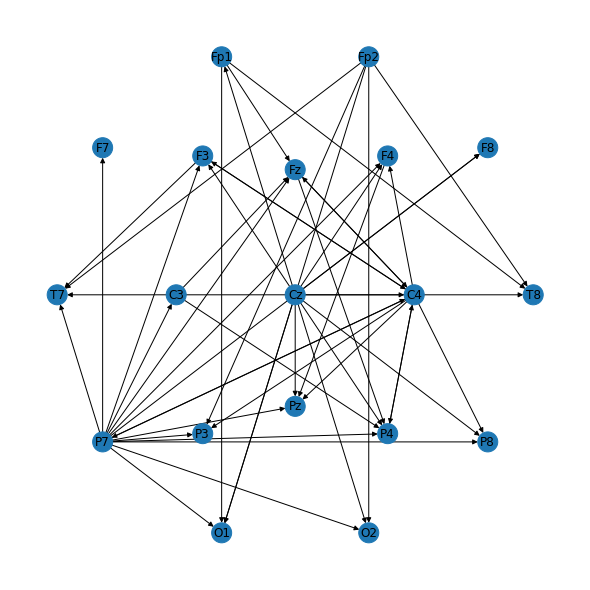

<Figure size 432x288 with 0 Axes>

In [34]:
plot_network(G, positions=position_dictionary)
plt.savefig('images/net19r2.png')

## 1.6

### Saving data for 2nd part

#### For the tasks 2.1 & 2.3

In [35]:
nx.write_gpickle(G_pdc, "saved_graphs/{}_pdc_binary_complete.gpickle".format(file_name))

In [36]:
nx.write_gpickle(G_dtf, "saved_graphs/{}_dtf_binary_complete.gpickle".format(file_name))

#### Task 2.4

In [37]:
densities = ["1", "5", "10", "20", "30", "50"]
networks = [pdc1, pdc5, pdc10, G_pdc, pdc30, pdc50]

In [38]:
for i in range(len(densities)):
    nx.write_gpickle(networks[i], "saved_graphs/{}_pdc_{}.gpickle".format(file_name, densities[i]))

####  Task 2.7

In [39]:
np.fill_diagonal(pdc_significance, 0)
G_pdc_weighted = nx.DiGraph(pdc_significance)
G_pdc_weighted = nx.relabel_nodes(G_pdc_weighted, label_dict)
G_pdc_weighted['Fc5']['Fc3']

{'weight': 0.10178522865914968}

In [40]:
nx.write_gpickle(G_pdc_weighted, "saved_graphs/{}_pdc_weighted_complete.gpickle".format(file_name))